# Profile Intel® oneAPI Deep Neural Network Library (oneDNN) Samples by using Verobse Mode and BenchDnn

## Learning Objectives
In this module the developer will:
* Learn how to run performance benchmarks for oneDNN primitives using benchDNN
* Learn how to use breakdown Verbose logs to profile oneDNN performance using verbose_converter 

Benchdnn is a tool provided by oneDNN to test both functionality and performance of oneDNN primitives. Using this tool devlopers can validate and recreate performance results for all supported oneDNN primitives.
 

## Prerequisites
***
### Prepare the build/run environment

In [1]:
# ignore all warning messages
import warnings
warnings.filterwarnings('ignore')
%autosave 0

Autosave disabled


In [2]:
# default path: /opt/intel/oneapi
%env ONEAPI_INSTALL=/opt/intel/oneapi

env: ONEAPI_INSTALL=/opt/intel/oneapi


In [3]:
import os
if os.path.isdir(os.environ['ONEAPI_INSTALL']) == False:
    print("Error! wrong oneAPI installation path")
else:
    print("Success! found oneAPI installation")

Success! found oneAPI installation


Clone the oneDNN repo to current directory 

In [ ]:
!git clone https://github.com/oneapi-src/oneDNN.git

#### Script - build.sh
The script **build.sh** encapsulates the compiler command and flags that will generate our benchDNN executable.

In [4]:
%%writefile build.sh
#!/bin/bash
source $ONEAPI_INSTALL/setvars.sh --force> /dev/null 2>&1
cd oneDNN
mkdir build
cd build

cmake .. 
make benchdnn

Writing build.sh


#### Submitting **build.sh**  to the job queue
Now we can submit the **build.sh** to the job queue.

##### NOTE - it is possible to execute any of the build and run commands in local environments.
To enable users to run their scripts both on the DevCloud or in local environments, this and subsequent training checks for the existence of the job submission command **qsub**.  If the check fails it is assumed that build/run will be local.

In [ ]:
!chmod 755 q;chmod 755 build.sh;if [ -x "$(command -v qsub)" ]; then ./q build.sh; else ./build.sh; fi

submit build.sh to icx node
Submitting job:
2015305.v-qsvr-1.aidevcloud
Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2015163.v-qsvr-1           ...ub-singleuser u165614         00:03:19 R jupyterhub     
2015305.v-qsvr-1           build.sh         u165614                0 Q batch          
Waiting for Output......................

## Running a benchDNN performance test

In benchdnn, execution iterates over all states when a problem description is parsed through as an argument. This means that options that are specified after descriptor won't be applied for the previous descriptor, only for the next one if/when met. 

``` sh
    ./benchdnn --DRIVER [COMMON-OPTIONS] [DRIVER-OPTIONS] PROBLEM-DESCRIPTION
```

Benchdnn supports command line options; either common or driver-specific together with default option values form a set of states. 

#### COMMON-OPTIONS
- Benchdnn offers a list of common options available to all drivers, users can refer to [`COMMON-OPTIONS`](https://github.com/oneapi-src/oneDNN/blob/master/tests/benchdnn/doc/knobs_common.md) for details on options supported across all the different drivers.

#### DRIVER-OPTIONS
Unlike common options, driver options are specific to each driver.

For our testing purposes, we will focus on the convolution driver. Here is an example of some of the driver options specific for (de)convolution:

 - `--dir={FWD_B [default], FWD_D, FWD_I, BWD_D, BWD_W, BWD_WB}` -- Specify propagation kind.

 - `--cfg={f32 [default], ...}` -- Specify data type.
 
 - `--stag={any [default], ...}` -- Specify physical source memory layout.

 - `--wtag={any [default], ...}` -- Specify physical weight memory layout.

 - `--dtag={any [default], ...}` -- Specify physical destination memory layout.

 - `--alg={DIRECT [default], WINO, AUTO}` -- Specify convolution algorithm.

 - `--attr-post-ops=STRING` -- Specify post operation primitive attribute. 
 

#### PROBLEM-DESCRIPTION
In this section, users will learn how to run a convolution benchdnn test with a specific problem description. Benchdnn supports two notions of a problem description: 
- Problem descriptors, 
- Dimensions (integer numbers) separated by x delimiter.

**The following table describes common problem descriptor entry names across different drivers:**


| Entry      | Description|
| :---       | :---
| g          | Groups (for grouped (de-)convolutions).|
| mb         | Minibatch (number of images processed at once).|
| ic, oc     | Input and output channels (aka feature maps).|
| id, ih, iw | Input depth, height and width.|
| od, oh, ow | Output depth, height and width.|
| kd, kh, kw | Kernel (filter, weights) depth, height and width.|
| sd, sh, sw | Stride over depth, height and width.|
| dd, dh, dw | Dilation by depth, height and width.|
| pd, ph, pw | Front, top and left padding.|
| n          | Descriptor name.|
| _          | Underscore. Optional delimiter between entries for readability.|

In our case for convolution the canonical form is:
```
    gXmbX_icXidXihXiwX_ocXodXohXowX_kdXkhXkwX_sdXshXswX_pdXphXpwX_ddXdhXdwX_nS
```



#### Script - run.sh
The script **run.sh** encapsulates the program for submission to the job queue for execution.

In this exercise, we use the problem descriptor to test for alexnet convolution - `g1mb256_ic3ih227iw227_oc96oh55ow55_kh11kw11_sh4sw4_ph0pw0_n"alexnet:conv1"`

Users can modify the paramaters and knobs below to expirement with the output.

In [4]:
%%writefile run.sh
#!/bin/bash
echo "########## Executing the run ##########"
export BENCHDNN_ROOT=oneDNN/build/tests/benchdnn
export PROBLEM=g1mb256ic3ih227iw227oc96oh55ow55kh11kw11sh4sw4ph0pw0n"alexnet:conv1"

./$BENCHDNN_ROOT/benchdnn --conv --mode=p --dir=FWD_D --alg=direct $PROBLEM &> alexnet_log.log 2>&1
cat alexnet_log.log

echo "########## Done with the run ##########"

Overwriting run.sh


In [5]:
!chmod 755 q;chmod 755 run.sh;if [ -x "$(command -v qsub)" ]; then ./q run.sh; else ./run.sh; fi

submit run.sh to icx node
Submitting job:
2042519.v-qsvr-1.aidevcloud
Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2042492.v-qsvr-1           ...ub-singleuser u165614         00:00:15 R jupyterhub     
2042519.v-qsvr-1           run.sh           u165614                0 Q batch          
Waiting for Output.........
########################################################################
#      Date:           Tue 15 Nov 2022 01:16:05 PM PST
#    Job ID:           2042519.v-qsvr-1.aidevcloud
#      User:           u165614
# Resources:           neednodes=1:icx:ppn=2,nodes=1:icx:ppn=2,walltime=06:00:00
########################################################################

########## Executing the run
Output template: perf,%engine%,%impl%,%name%,%prb%,%Gops%,%-time%,%-Gflops%,%0time%,%0Gflops%
perf,cpu,jit:avx512_core,alexnet:conv1,--conv --mode=P --dir=FWD_D g1mb256ic3ih227oc96oh

  
## Running a benchDNN test with Verbose

***
In this section, we enable verbose mode on the built sample from the previous section, and users can see different results from CPU and GPU.  
Refer to the [link](https://oneapi-src.github.io/oneDNN/dev_guide_verbose.html) for detailed verbose mode information

When the feature is enabled at build-time, you can use the DNNL_VERBOSE environment variable to turn verbose mode on and control the level of verbosity.

|Environment variable|Value|Description|
|:-----|:----|:-----|
|DNNL_VERBOSE| 0 |no verbose output (default)|
||1|primitive information at execution|
||2|primitive information at creation and execution|  


Users could also enable DNNL_VERBOSE with timestamps by DNNL_VERBOSE_TIMESTAMP environment variable.  

|Environment variable|Value|Description|
|:-----|:----|:-----|
|DNNL_VERBOSE_TIMESTAMP| 0 |display timestamps disabled (default)|
||1| display timestamps enabled|


#### Script - run_blocked_v.sh
The script **run_blocked_v.sh** encapsulates the program for submission to the job queue for execution.

In this particular script, we will run the same benchdnn script as before with two changes, firstly we will be running with DNNL_VERBOSE enabled which will help us later understand the program execution in more detail. The second change is we will be forcing blocked format (nChw16c) in the weight layers of the convolution using the driver option `--wtag = aBx16b`

In [8]:
%%writefile run_blocked_v.sh
#!/bin/bash
echo "########## Executing the run ##########"
export ONEDNN_VERBOSE=1
export BENCHDNN_ROOT=oneDNN/build/tests/benchdnn
export PROBLEM=g1mb256ic3ih227iw227oc96oh55ow55kh11kw11sh4sw4ph0pw0n"alexnet:conv1"

./$BENCHDNN_ROOT/benchdnn --conv --mode=p --dir=FWD_D --wtag=aBx16b --alg=direct $PROBLEM &> alexnet_blocked_log.log 2>&1

echo "########## Done with the run ##########"

Overwriting run_v.sh


#### Script - run_plain_v.sh
The script **run_plain_v.sh** encapsulates the program for submission to the job queue for execution.

In this new script, we will keep everything the same as before and change the weight memory format to plain (nhwc). `--wtag = abx`

In [60]:
%%writefile run_plain_v.sh
#!/bin/bash
echo "########## Executing the run ##########"
export ONEDNN_VERBOSE=1
export BENCHDNN_ROOT=oneDNN/build/tests/benchdnn
export PROBLEM=g1mb256ic3ih227iw227oc96oh55ow55kh11kw11sh4sw4ph0pw0n"alexnet:conv1"

./$BENCHDNN_ROOT/benchdnn --conv --mode=p --dir=FWD_D --wtag=abx --alg=direct $PROBLEM &> alexnet_plain_log.log 2>&1

echo "########## Done with the run ##########"

Overwriting run_plain_v.sh


In [61]:
! chmod 755 run_plain_v.sh;if [ -x "$(command -v qsub)" ]; then ./q run_plain_v.sh; else ./run_plain_v.sh; fi

submit run_plain_v.sh to icx node
Submitting job:
2064010.v-qsvr-1.aidevcloud
Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2063736.v-qsvr-1           ...ub-singleuser u165614         00:00:56 R jupyterhub     
2064006.v-qsvr-1           run_blocked_v.sh u165614                0 Q batch          
2064010.v-qsvr-1           run_plain_v.sh   u165614                0 Q batch          
Waiting for Output..........
########################################################################
#      Date:           Tue 29 Nov 2022 09:28:14 PM PST
#    Job ID:           2064010.v-qsvr-1.aidevcloud
#      User:           u165614
# Resources:           cput=35:00:00,neednodes=1:icx:ppn=2,nodes=1:icx:ppn=2,walltime=06:00:00
########################################################################

########## Executing the run ##########
########## Done with the run ##########

####################

#### Submitting  **run_v.sh** to the job queue
Now we can submit the **run_v.sh** to the job queue.

In [49]:
! chmod 755 run_blocked_v.sh;if [ -x "$(command -v qsub)" ]; then ./q run_blocked_v.sh; else ./run_blocked_v.sh; fi

submit run_blocked_v.sh to icx node
Submitting job:
2064008.v-qsvr-1.aidevcloud
Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2063736.v-qsvr-1           ...ub-singleuser u165614         00:00:52 R jupyterhub     
2064006.v-qsvr-1           run_blocked_v.sh u165614                0 R batch          
2064008.v-qsvr-1           run_blocked_v.sh u165614                0 Q batch          
Waiting for Output......
########################################################################
#      Date:           Tue 29 Nov 2022 09:23:46 PM PST
#    Job ID:           2064008.v-qsvr-1.aidevcloud
#      User:           u165614
# Resources:           cput=35:00:00,neednodes=1:icx:ppn=2,nodes=1:icx:ppn=2,walltime=06:00:00
########################################################################

########## Executing the run ##########
########## Done with the run ##########

######################

### (Optional) BenchDNN with GPU

In this optional section users can build benchdnn with GPU support and run GPU performance benchmarking.

#### Script - build_gpu.sh
The script **build_gpu.sh** encapsulates the compiler command and flags that will generate our benchDNN executable with DPCPP GPU runtime support.

In [ ]:
%%writefile build_gpu.sh
#!/bin/bash
source /opt/intel/oneapi/setvars.sh --force
cd oneDNN

rm -rf build_gpu
mkdir build_gpu
cd build_gpu
 
export CC=icx
export CXX=icpx

cmake -DDNNL_GPU_RUNTIME=SYCL ..
make benchdnn

#### Submitting  **build_gpu.sh** to the job queue
Submit the **build_gpu.sh** to the job queue.

In [ ]:
!chmod 755 q;chmod 755 build_gpu.sh;if [ -x "$(command -v qsub)" ]; then ./q build_gpu.sh; else ./build_gpu.sh; fi

#### Script - run_gpu.sh
The script **run_gpu.sh** runs the benchdnn while invoking --engine=gpu:0 to run on the GPU:

In [ ]:
%%writefile run_gpu.sh
#!/bin/bash
echo "########## Executing the run ##########"
export ONEDNN_VERBOSE=1
export BENCHDNN_ROOT=oneDNN/build_gpu/tests/benchdnn
export PROBLEM=g1mb256ic3ih227iw227oc96oh55ow55kh11kw11sh4sw4ph0pw0n"alexnet:conv1"

./$BENCHDNN_ROOT/benchdnn --conv --engine=gpu:0 --mode=p --alg=direct $PROBLEM &> alexnet_gpu.log 2>&1

echo "########## Done with the run ##########"

#### Submitting  **run_gpu.sh** to the job queue
Submit the **run_gpu.sh** to the job queue.

In [ ]:
! chmod 755 run_gpu.sh;if [ -x "$(command -v qsub)" ]; then ./q run_gpu.sh; else ./run_gpu.sh; fi

## Analyze Verbose Logs
***


### Step 1: List out all oneDNN verbose logs


In [4]:
import os
filenames= os.listdir (".") 
result = []
keyword = ".log"
for filename in filenames: 
    if filename.find(keyword) != -1:
        result.append(filename)
result.sort()

index =0 
for folder in result:
    print(" %d : %s " %(index, folder))
    index+=1

 0 : alexnet_blocked_log.log 
 1 : alexnet_log.log 
 2 : alexnet_log_v.log 
 3 : alexnet_log_v2.log 
 4 : alexnet_plain_log.log 
 5 : test_log.log 
 6 : unet_log.log 
 7 : unet_log_verbose.log 


### Step 2:  Parse verbose log and get the data back

Users can pick a verbose log to analyze from step 1 and modify the index below.

In [5]:
FdIndex=0

#### Verbose log converter

In [6]:
import sys
sys.path.insert(1, './oneDNN/scripts/verbose_converter/')
import verbose_converter

logfile = result[FdIndex]
cur_log = open(logfile, "r")
output = verbose_converter.convert(0, 'oneDNN', cur_log, 'generate',
         'breakdown', 1, agg_keys=['prim_kind'])
print(output)


(0, {'all': 'prim_kind,ncalls,time(ms),overall%,agg_ncalls(avg),agg_time(ms),agg_overall%\nconvolution,283,3019.48,99.39,283.00,3019.48,99.39\nreorder,2,18.67,0.61,142.50,3038.16,100.00'})


The output of the verbose_converter from last step is not fully parsed and hard to read. The helper function below *cleanup* will further parse the output from our breakdown.

In [7]:
def cleanup(breakdown):
    temp = ' '.join([str(elem) for i,elem in enumerate(breakdown)])
    parsed_breakdown = temp.split("'")[3]
    return parsed_breakdown.split("\\n")

In [8]:
log_breakdown = cleanup(output)
for row in log_breakdown:
    print(row)

prim_kind,ncalls,time(ms),overall%,agg_ncalls(avg),agg_time(ms),agg_overall%
convolution,283,3019.48,99.39,283.00,3019.48,99.39
reorder,2,18.67,0.61,142.50,3038.16,100.00


>Note: Users could also use the verbose converter via the command line 

### Step 3:  Visualize the verbose breakdown

Using the verbose log breakdown we got from previous steps, users can visualize the data to get a better understanding of the execution stack.
Users can run the script below to generate a pie chart of the different primitive execution times using pandas.

In [9]:
# Import required packages
import pandas as pd
import numpy as np

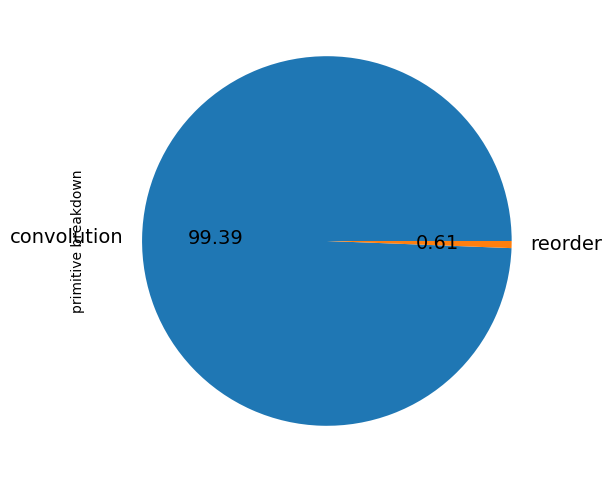

In [10]:
prim_time = []
prim_kinds = []
prim_ncalls = []

# Extract number of calls, exec time and kind from breakdown
if len(log_breakdown) > 1:
    for i in range(1, len(log_breakdown)):
        temp = log_breakdown[i].split(',')
        prim_time.append(float(temp[2]))
        prim_ncalls.append(float(temp[1]))
        prim_kinds.append(temp[0])

# Create the pandas object with parsed data
pd_breakdown = pd.Series(prim_time, prim_kinds, name="primitive breakdown")

# Display the pie chart
pd_breakdown.plot.pie(
    autopct="%.2f",
    fontsize=14,
    figsize=(6, 6),
);

Users can also output a simplified table of the different oneDNN primtives used sing the same data for our previous script.

In [11]:
table = [prim_time, prim_ncalls]
pd_table = pd.DataFrame(table, columns = ['time(ms)', 'ncalls'], index=prim_kinds)
print(pd_table)

             time(ms)  ncalls
convolution   3019.48   18.67
reorder        283.00    2.00


### Step 4 [Optional]:  Compare another log

Repeat steps 2-3 with a different log and compare the results. 
Users are encouraged to experiement with different benchDNN problem arguments.

***
# Summary
In this lab the developer learned the following:
* How to run performance benchmarks for oneDNN primitives using benchDNN
* How to use breakdown Verbose logs to profile oneDNN performance using verbose_converter 
